In [ ]:
# --------------------------
# 0. Connect to Google Drive
# --------------------------
from google.colab import drive
import os

drive.mount('/content/drive')

# Define paths
drive_data_path = '/content/drive/MyDrive/Lung_Cancer_Split'
drive_model_path = '/content/drive/MyDrive/xgboost_hybrid_model.json'
drive_feature_path = '/content/drive/MyDrive/mobilenet_features.npy'
drive_label_path = '/content/drive/MyDrive/mobilenet_labels.npy'

Mounted at /content/drive


In [ ]:
# --------------------------
# 1. Imports and Setup
# --------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt # Added matplotlib
import seaborn as sns # Added seaborn

In [ ]:
# --------------------------
# 2. Load and Preprocess Data (Streaming - Low RAM)
# --------------------------
import os # Ensure os is imported in this cell as well
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Ensure ImageDataGenerator is imported

img_height, img_width = 224, 224
batch_size = 32

# Assuming drive_data_path is defined in a previous cell and accessible
train_dir = os.path.join(drive_data_path, "train")
val_dir = os.path.join(drive_data_path, "val")
test_dir = os.path.join(drive_data_path, "test")

full_datagen = ImageDataGenerator(rescale=1./255)
train_val_generator = full_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12008 images belonging to 3 classes.


In [ ]:
# --------------------------
# 3. CNN Feature Extraction (Fast, GPU-Optimized)
# --------------------------
import numpy as np # Ensure numpy is imported
from tensorflow.keras.applications import MobileNetV2 # Ensure MobileNetV2 is imported

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False

features = base_model.predict(train_val_generator, verbose=1)
labels = train_val_generator.classes

# Save extracted features and labels to Drive
# Assuming drive_feature_path and drive_label_path are defined in a previous cell and accessible
np.save(drive_feature_path, features)
np.save(drive_label_path, labels)

print(f"Saved extracted features to: {drive_feature_path}")
print(f"Saved extracted labels to: {drive_label_path}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


376/376 ━━━━━━━━━━━━━━━━━━━━ 3759s 10s/step
Saved extracted features to: /content/drive/MyDrive/mobilenet_features.npy
Saved extracted labels to: /content/drive/MyDrive/mobilenet_labels.npy


In [ ]:
# --------------------------
# 4. Train XGBoost Classifier
# --------------------------
from xgboost import XGBClassifier # Ensure XGBClassifier is imported
import numpy as np # Ensure numpy is imported if features and labels are used


clf = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(features, labels)

# Save trained model to Drive
# Assuming drive_model_path is defined in a previous cell and accessible
clf.save_model(drive_model_path)
print(f"XGBoost model saved to: {drive_model_path}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:31:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model saved to: /content/drive/MyDrive/xgboost_hybrid_model.json


Found 1501 images belonging to 3 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 452s 10s/step

Confusion Matrix:
[[489   1  11]
 [  0 500   0]
 [ 14   0 486]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       501
           1       1.00      1.00      1.00       500
           2       0.98      0.97      0.97       500

    accuracy                           0.98      1501
   macro avg       0.98      0.98      0.98      1501
weighted avg       0.98      0.98      0.98      1501



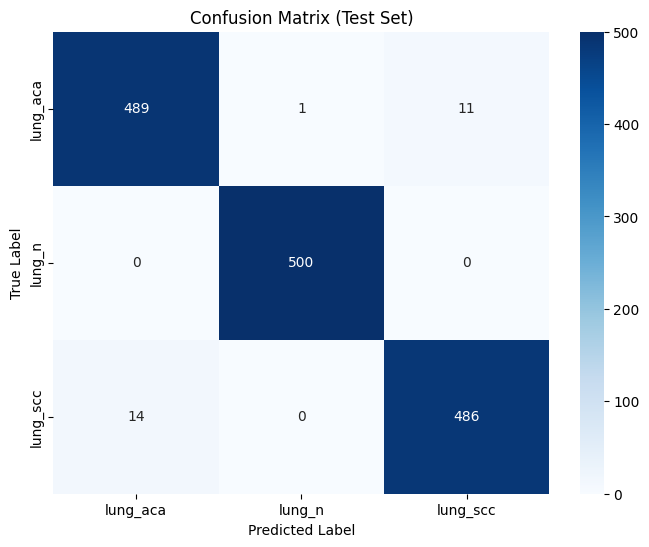

In [ ]:
# --------------------------
# 5. Test Evaluation
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix # Ensure metrics are imported
import numpy as np # Ensure numpy is imported if used
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import seaborn as sns # Ensure seaborn is imported


# Assuming full_datagen, test_dir, img_height, img_width, batch_size, base_model, and clf are defined in previous cells and accessible
test_generator = full_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

x_test = base_model.predict(test_generator, verbose=1)
y_test_labels = test_generator.classes

pred_labels = clf.predict(x_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, pred_labels))
print("\nClassification Report:")
print(classification_report(y_test_labels, pred_labels))

# Generate and display the confusion matrix as an image
cm = confusion_matrix(y_test_labels, pred_labels)
class_labels = list(test_generator.class_indices.keys()) # Get class labels from the generator

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

Found 1501 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 452s 10s/step

Validation Confusion Matrix:
[[486   2  13]
 [  0 500   0]
 [ 14   0 486]]

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       501
           1       1.00      1.00      1.00       500
           2       0.97      0.97      0.97       500

    accuracy                           0.98      1501
   macro avg       0.98      0.98      0.98      1501
weighted avg       0.98      0.98      0.98      1501



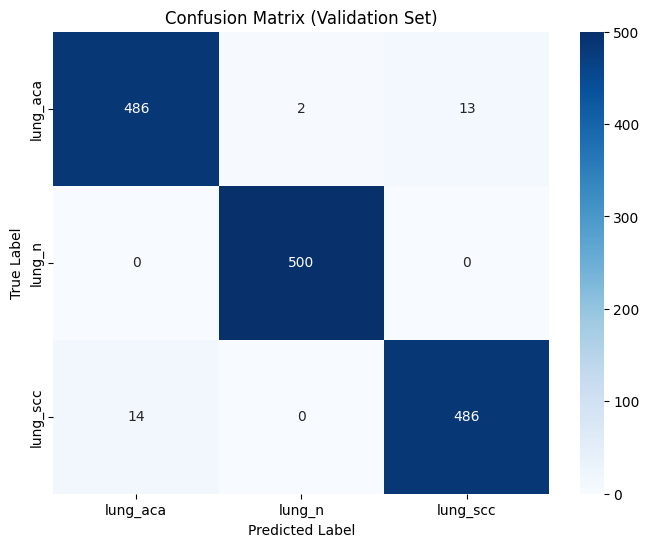

In [ ]:
# --------------------------
# 6. Optional: Validation Evaluation
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix # Ensure metrics are imported
import numpy as np # Ensure numpy is imported if used
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import seaborn as sns # Ensure seaborn is imported


# Assuming full_datagen, val_dir, img_height, img_width, batch_size, base_model, and clf are defined in previous cells and accessible
val_generator = full_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

x_val = base_model.predict(val_generator, verbose=1)
y_val_labels = val_generator.classes

val_pred_labels = clf.predict(x_val)
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val_labels, val_pred_labels))
print("\nValidation Classification Report:")
print(classification_report(y_val_labels, val_pred_labels))

# Generate and display the confusion matrix as an image
val_cm = confusion_matrix(y_val_labels, val_pred_labels)
class_labels = list(val_generator.class_indices.keys()) # Get class labels from the generator

plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()